# Download kaggle dataset

In [1]:
'''
import shutil
shutil.rmtree('./content/Released_Data', ignore_errors=True)
shutil.rmtree('./content/sample_data', ignore_errors=True)
shutil.rmtree('./content/test_shuffle', ignore_errors=True)
shutil.rmtree('./content/train_shuffle', ignore_errors=True)
'''
#Download the dataset from Dropbox
!wget -O released_data.zip "https://www.dropbox.com/s/c2dvapqb613ukhw/Released_Data-20221201T215316Z-001.zip?dl=0"

#Unzip the train, test and other datasets
!unzip -q released_data.zip
!unzip -q ./Released_Data/test_shuffle.zip
!unzip -q ./Released_Data/train_shuffle.zip

--2022-12-16 17:10:24--  https://www.dropbox.com/s/c2dvapqb613ukhw/Released_Data-20221201T215316Z-001.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/c2dvapqb613ukhw/Released_Data-20221201T215316Z-001.zip [following]
--2022-12-16 17:10:24--  https://www.dropbox.com/s/raw/c2dvapqb613ukhw/Released_Data-20221201T215316Z-001.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1fe3baf1750fc0b91651b53016.dl.dropboxusercontent.com/cd/0/inline/ByvyFg5PilxKVmi2W3IuuiG0y9GTLrT_J8y23jPQZCvZnqJ_zeOAsbioZ-PKIaifIyxpuhgwRFw-3TICdsGtx7cg-19lujtCq3FPXR2-XdqQbbEP-ZpJMJh7HZYTcKm4G2kNyQN19ulinEwXkgMI7aptC-hELaPb7maZjPjuRBRJNA/file# [following]
--2022-12-16 17:10:25--  https://uc1fe3baf1750fc0b91651b53016.dl.dropboxusercontent.com/cd/0/i

# Siamese Network

In [11]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
import os
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
from PIL import Image
from google.colab.patches import cv2_imshow
import albumentations as A
from albumentations.pytorch import ToTensorV2

device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'

print(device)

cuda


## Data Preprocessing

Common names:  []
Error names:  []
Total number of images:  6472
Number of training images:  (5738, 3)
Number of validation images:  (734, 3)
328.jpg 1 78 (64, 64, 3)
<class 'numpy.ndarray'> (64, 64, 3)


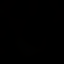

0.jpg 1 63 (64, 64, 3)


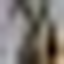

9066.jpg (64, 64, 3)


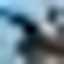

In [15]:
'''
base_dir = r'/content/drive/MyDrive/fruits-360/Training/'
train_test_split = 0.7
no_of_files_in_each_class = 10

#Read all the folders in the directory
folder_list = os.listdir(base_dir)
print( len(folder_list), "categories found in the dataset")

#Declare training array
cat_list = []
x = []
y = []
y_label = 0

#Using just no_of_files_in_each_class images per category
for folder_name in folder_list:
    files_list = os.listdir(os.path.join(base_dir, folder_name))
    if len(files_list) < no_of_files_in_each_class:
      print(f"skipping {folder_name}")
      continue
    temp=[]
    for file_name in files_list[:no_of_files_in_each_class]:
        temp.append(len(x))
        x.append(np.asarray(Image.open(os.path.join(base_dir, folder_name, file_name)).convert('RGB').resize((100, 100))))
        y.append(y_label)
    y_label+=1
    cat_list.append(temp)

cat_list = np.asarray(cat_list)
x = np.asarray(x)/255.0
y = np.asarray(y)
print('X, Y shape',x.shape, y.shape, cat_list.shape)
'''


full_imgs = np.array(os.listdir('./train_shuffle'))
full_labels = pd.read_csv('./Released_Data/train_data.csv').to_numpy()

labels_list = [set(),set(),set()]

#prepare lists based on the super classes
labels_list = [{}, {}, {}]
val_labels_list = [{}, {}, {}]

for i in range(len(full_labels)):
    if full_labels[i][2] in labels_list[full_labels[i][1]]:
        labels_list[full_labels[i][1]][full_labels[i][2]] += 1
    else:
        labels_list[full_labels[i][1]][full_labels[i][2]] = 1
        val_labels_list[full_labels[i][1]][full_labels[i][2]] = 0

# Check the number of times each sub class appears
# print(dict(sorted(labels_list[0].items(), key=lambda item: item[1])))
# print(dict(sorted(labels_list[1].items(), key=lambda item: item[1])))
# print(dict(sorted(labels_list[2].items(), key=lambda item: item[1])))

#Splitting the train and validation datasets (90 - 10 split)
train_imgs = []
val_imgs = []

for i in range(len(full_labels)):
    if val_labels_list[full_labels[i][1]][full_labels[i][2]] <= (0.1)*(labels_list[full_labels[i][1]][full_labels[i][2]]):
        val_labels_list[full_labels[i][1]][full_labels[i][2]] += 1
        val_imgs.append(full_labels[i][0])
    else:
        train_imgs.append(full_labels[i][0])

#Check if there is any common image between training and validation datasets
common_names = [name for name in train_imgs if name in val_imgs]
print("Common names: ", common_names)

train_data = full_labels[np.isin(full_labels[:, 0], train_imgs)]
val_data = full_labels[np.isin(full_labels[:, 0], val_imgs)]

#Check if there is any name missing from the training dataset
ver_train_names = train_data[:, 0]
error_names = [name for name in ver_train_names if name not in train_imgs]
print("Error names: ", error_names)

print("Total number of images: ", len(full_imgs))
print("Number of training images: ", train_data.shape)
print("Number of validation images: ", val_data.shape)


import albumentations as A
from albumentations.pytorch import ToTensorV2

full_test_imgs = os.listdir("./test_shuffle")

for i in range(len(train_data)):
    if train_data[i][1] == 0:
        train_img = cv2.imread(os.path.join('train_shuffle', train_data[i][0]), cv2.IMREAD_UNCHANGED)
        train_img = cv2.resize(train_img, (64, 64), interpolation = cv2.INTER_CUBIC)
        cv2.imwrite("sample_bird.png", train_img)
    
    if train_data[i][1] == 2:
        train_img = cv2.imread(os.path.join('train_shuffle', train_data[i][0]), cv2.IMREAD_UNCHANGED)
        train_img = cv2.resize(train_img, (64, 64), interpolation = cv2.INTER_CUBIC)
        cv2.imwrite("sample_reptile.png", train_img)

train_img = cv2.imread(os.path.join('train_shuffle', train_data[0][0]), cv2.IMREAD_UNCHANGED)
train_img = cv2.resize(train_img, (64, 64), interpolation = cv2.INTER_CUBIC)
cv2.imwrite("sample_dog.png", train_img)
print(train_data[0][0], train_data[0][1], train_data[0][2], train_img.shape)
transform_data = A.Compose([A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p=1)])
train_img = transform_data(image = train_img)['image']
print(type(train_img), train_img.shape)
#print(np.unique(train_img))
cv2_imshow(train_img)

val_img = cv2.imread(os.path.join('train_shuffle', val_data[0][0]), cv2.IMREAD_UNCHANGED)
val_img = cv2.resize(val_img, (64, 64), interpolation = cv2.INTER_CUBIC)
print(val_data[0][0], val_data[0][1], val_data[0][2], val_img.shape)
cv2.imwrite("sample_val.png", val_img)
cv2_imshow(val_img)

test_img = cv2.imread(os.path.join('test_shuffle', full_test_imgs[0]), cv2.IMREAD_UNCHANGED)
test_img = cv2.resize(test_img, (64, 64), interpolation = cv2.INTER_CUBIC)
print(full_test_imgs[0], test_img.shape)
cv2.imwrite("sample_test.png", test_img)
cv2_imshow(test_img)


class KaggleDataset(nn.Module):
    def __init__(self, mode = 'train'):
        super(KaggleDataset, self).__init__()
        self.mode = mode

        if mode == 'train':
            self.dataset = train_data
        else:
            self.dataset = val_data
    
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img_name = self.dataset[idx][0]
        img = cv2.imread(os.path.join('train_shuffle', img_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    #convert image from BGR to RGB format

        super_class = torch.tensor(self.dataset[idx][1], dtype = torch.float32)
        sub_class = torch.tensor(self.dataset[idx][2], dtype = torch.float32)

        apply_transform = self.transform_data()
        image = apply_transform(image = img)['image']

        return image, super_class, sub_class

    def transform_data(self):

        if self.mode == 'train':
            transform_data = A.Compose(
              [
                  #always resize the image to 329x224
                  #A.Resize(height = 329, width= 224, interpolation = cv2.INTER_AREA, p=1),
                  A.HorizontalFlip(p=0.4),  
                  A.ShiftScaleRotate(shift_limit=0.025, scale_limit=0, rotate_limit=15, p=0.5),
                  #A.RandomCrop(height = 224, width = 224, p=1),
                  #randomly change brightness, contrast, and saturation of the image 50% of the time
                  A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue = 0, p=0.5), 
                  A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p=1), 
                  ToTensorV2(p=1),
              ])
        else:     #augmentations during validation and testing
          transform_data = A.Compose(
          [
              #always resize the image to 329x224
              #A.Resize(height = 329, width = 224, p=1),   
              A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p=1),
              ToTensorV2(p=1),
          ])
    
        return transform_data

In [23]:
# Adapt x input dimension to PyTorch format.
'''
x = x.transpose(0, 3, 1, 2)
print('X, Y shape',x.shape, y.shape, cat_list.shape)
'''
from torch.utils.data import TensorDataset, DataLoader

train_dataset = KaggleDataset(mode='train')
val_dataset = KaggleDataset(mode='val')
    
train_loader = DataLoader(dataset = train_dataset, batch_size = 64, shuffle = True, num_workers = 8, pin_memory = True)
val_loader = DataLoader(dataset = val_dataset, batch_size = 64, shuffle = False)


# print(len(train_loader))
# print(len(val_loader))

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Train Test Split

In [ ]:
'''
train_size = int(len(folder_list)*train_test_split)
test_size = len(folder_list) - train_size
print(train_size, 'classes for training and', test_size, ' classes for testing')

train_files = train_size * no_of_files_in_each_class

#Training Split
x_train = x[:train_files]
y_train = y[:train_files]
cat_train = cat_list[:train_size]

#Validation Split
x_val = x[train_files:]
y_val = y[train_files:]
cat_test = cat_list[train_size:]

print('X&Y shape of training data :',x_train.shape, 'and', y_train.shape, cat_train.shape)
print('X&Y shape of testing data :' , x_val.shape, 'and', y_val.shape, cat_test.shape)
'''

## Generating Batch

In [ ]:
'''
def get_batch(batch_size=64):
    
    temp_x = x_train
    temp_cat_list = cat_train
    start=0
    end=train_size
    batch_x=[]
        
    batch_y = np.zeros(batch_size)
    batch_y[int(batch_size/2):] = 1
    np.random.shuffle(batch_y)
    
    class_list = np.random.randint(start, end, batch_size) 
    batch_x.append(np.zeros((batch_size, 3, 100, 100)))
    batch_x.append(np.zeros((batch_size, 3, 100, 100)))

    for i in range(0, batch_size):
        batch_x[0][i] = temp_x[np.random.choice(temp_cat_list[class_list[i]])]
        #If train_y has 0 pick from the same class, else pick from any other class
        if batch_y[i]==0:
            batch_x[1][i] = temp_x[np.random.choice(temp_cat_list[class_list[i]])]

        else:
            temp_list = np.append(temp_cat_list[:class_list[i]].flatten(), temp_cat_list[class_list[i]+1:].flatten())
            batch_x[1][i] = temp_x[np.random.choice(temp_list)]
            
    return(batch_x, batch_y)
  '''

## Siamese Network

In [8]:
#Building a sequential model
class CnnNetwork(nn.Module):
    def __init__(self):
        super(CnnNetwork, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(3, 64, 10)
        self.conv2 = nn.Conv2d(64, 128, 7)
        self.conv3 = nn.Conv2d(128, 128, 4)
        self.conv4 = nn.Conv2d(128, 256, 4)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(256 * 4, 1024)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = F.max_pool2d(F.relu(self.conv4(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.sigmoid(self.fc1(x))
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn = CnnNetwork()
        self.fc1 = nn.Linear(1024, 1)

    def forward(self, left, right):
        x = self.cnn(left)
        y = self.cnn(right)
        diff = torch.abs(x - y)
        # z = self.fc1(diff)
        z = F.sigmoid(self.fc1(diff))
        return z



## N-way one-shot Learning

In [ ]:
def nway_one_shot(n_way, n_val):
    
    temp_x = x_val
    temp_cat_list = cat_test
    batch_x=[]
    x_0_choice=[]
    n_correct = 0
   
    class_list = np.random.randint(train_size+1, len(cat_list)-1, n_val)

    for i in class_list:  
        j = np.random.choice(cat_list[i])
        temp=[]
        temp.append(np.zeros((n_way, 3, 100, 100)))
        temp.append(np.zeros((n_way, 3, 100, 100)))
        for k in range(0, n_way):
            temp[0][k] = x[j]
            # 2 is arbitrary here, as 0 is the default number when all numbers
            # are equal, which leads to wrong conclusions.
            if k==2:
                temp[1][k] = x[np.random.choice(cat_list[i])]
            else:
                temp[1][k] = x[np.random.choice(np.append(cat_list[:i].flatten(), cat_list[i+1:].flatten()))]

        result = siamese_net(torch.Tensor(temp[0]).cuda(), torch.Tensor(temp[1]).cuda())
        result = result.flatten().tolist()
        result_index = result.index(min(result))
        if result_index == 2:
            n_correct = n_correct + 1
    print(n_correct, "correctly classified among", n_val)
    accuracy = (n_correct*100)/n_val
    return accuracy

In [ ]:
# Tools to display batch data graphically

def display_batch(batch_x, batch_y, batch_size=64):
  num = int(batch_size ** 0.5)
  combined_left = np.zeros((num*100, num*100, 3))
  combined_right = np.zeros((num*100, num*100, 3))
  count = 0
  for i in range(num):
    for j in range(num):
      left_image = batch_x[0][count].transpose(1, 2, 0)
      right_image = batch_x[1][count].transpose(1, 2, 0)
      combined_left[i*100:(i+1)*100, j*100:(j+1)*100, :] = left_image
      combined_right[i*100:(i+1)*100, j*100:(j+1)*100, :] = right_image
      count += 1
  plt.imshow(combined_left)
  plt.show()
  plt.imshow(combined_right)
  plt.show()
  print("batch_y is")
  print(np.reshape(batch_y, (-1, num)))

## Training the Model

In [13]:
'''
epochs = 10
n_way = 20
n_val = 100
batch_size = 64

loss_list=[]
accuracy_list=[]
for epoch in range(epochs):
    if epoch == 0:
        accuracy = nway_one_shot(n_way, n_val)

    batch_x, batch_y = get_batch(batch_size)
    # display_batch(batch_x, batch_y)
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    siamese_outputs = siamese_net(torch.Tensor(batch_x[0]).cuda(), torch.Tensor(batch_x[1]).cuda())
    outputs = loss(siamese_outputs, torch.Tensor(batch_y).reshape(64, 1).cuda())
    outputs.backward()
    optimizer.step()

    print('Epoch:', epoch, ', Loss:',outputs)
    loss_list.append((epoch,outputs.item()))
    # print statistics
    if epoch % 250 == 0:
        print("=============================================")
        accuracy = nway_one_shot(n_way, n_val)
        accuracy_list.append((epoch, accuracy))
        print('Accuracy as of', epoch, 'epochs:', accuracy)
        print("=============================================")
        if(accuracy>90):
            print("Achieved more than 90% Accuracy")
'''

# Will contain utility functions used for training the model
import torch
import os
import copy
from tqdm import tqdm
from time import sleep
from torch.utils.tensorboard import SummaryWriter
import time

#Training Function
def fit_classifier(model, train_loader, val_loader, optimizer, loss_func, epochs=10, initial_epoch=0, device='cpu', name='siamese'):
    '''
    function to train a classifier model.
    args:
        model - the model to be trained
        train_loader - Dataloader() for train set
        val_loader - Dataloader() for val set
        optimizer - optimization algorithm for updating weights
        loss_func - loss function to be used
    
    keyword args:
        epochs - Number of training epochs (default=10)
        initial_epoch - The starting epoch
        device - the device for training (default='cpu')
        name - Name for saving the model
    
    returns: Nothing
    
    '''
    
    model = model.to(device, non_blocking=True)
    
    # Save the models based on the super and sub class validation accuracies
    best_super_acc = torch.tensor([0.]).to(device, non_blocking=True)
    best_sub_acc = torch.tensor([0.]).to(device, non_blocking=True)
    
    #create the logger object
    writer = SummaryWriter()
    start_time = time.time()
    
    #Iterate epochs
    for epoch in range(initial_epoch, initial_epoch + epochs):
        #Each epoch has a training phase and validation phase
        for phase in ['train','val']:
            data_loader = None
            if phase == 'train':
                #Set train mode
                model.train()
                data_loader = train_loader
            else:
                #Set Eval mode
                model.eval()
                data_loader = val_loader
          
            running_super_loss = 0.
            running_sub_loss = 0.
            running_super_corrects = torch.tensor([0.]).to(device, non_blocking=True)
            running_sub_corrects = torch.tensor([0.]).to(device, non_blocking=True)
            
            #tqdm for observing the progress
            with tqdm(data_loader, unit="batch") as tepoch:
                #Iterate batches
                for itr, (images, super_labels, sub_labels) in enumerate(tepoch):
                    tepoch.set_description(f"Epoch {(epoch)} {phase}")
                    images = images.to(device, non_blocking=True)

                    super_labels = super_labels.long().to(device, non_blocking=True)
                    sub_labels = sub_labels.long().to(device, non_blocking=True)
                    
                    optimizer.zero_grad()
                    
                    #Set gradient calculation only for training phase
                    with torch.set_grad_enabled(phase == 'train'):
                        #super_outputs, sub_outputs = model(images)
                        sub_outputs = model(images)

                        #super_loss = loss_func(super_outputs, super_labels)
                        sub_loss = loss_func(sub_outputs, sub_labels)

                        #super_preds = torch.argmax(super_outputs, dim=1)
                        sub_preds = torch.argmax(sub_outputs, dim=1)

                        #loss = 5 * super_loss + sub_loss
                        loss = sub_loss
                        
                        #Do backprop only during training
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    #running_super_loss += 5 * super_loss.item() * images.size(0)
                    running_sub_loss += sub_loss.item() * images.size(0)
                    #running_super_corrects += torch.sum(super_preds == super_labels)
                    running_sub_corrects += torch.sum(sub_preds == sub_labels)
                    
                    if phase == 'train':
                        writer.add_scalar("Batch_Loss/" + phase, loss.item(), epoch * len(data_loader) + itr)
                        # writer.add_scalar("Batch_Accuracy_Super_Class/" + phase,
                        #                   (torch.sum(super_preds == super_labels)/(images.shape[0])).item(),
                        #                   epoch * len(data_loader) + itr)
                        writer.add_scalar("Batch_Accuracy_Sub_Class/" + phase,
                                          (torch.sum(sub_preds == sub_labels)/(images.shape[0])).item(),
                                          epoch * len(data_loader) + itr)
                    
                    tepoch.set_postfix(loss=loss.item(),
                              #super_class_accuracy=(torch.sum(super_preds == super_labels)/(images.shape[0])).item(),
                              sub_class_accuracy=(torch.sum(sub_preds == sub_labels)/(images.shape[0])).item())
                
                #epoch_super_loss = running_super_loss / len(data_loader.dataset)
                epoch_sub_loss = running_sub_loss / len(data_loader.dataset)
                #epoch_super_acc = running_super_corrects.float() / (len(data_loader.dataset))
                epoch_sub_acc = running_sub_corrects.float() / (len(data_loader.dataset))

                #print(f"Epoch {(epoch)} {phase} Super Class loss: {epoch_super_loss} Super Class acc: {epoch_super_acc.item()} Sub Class loss: {epoch_sub_loss} Sub Class acc: {epoch_sub_acc.item()}")
                print(f"Epoch {(epoch)} {phase} Sub Class loss: {epoch_sub_loss} Sub Class acc: {epoch_sub_acc.item()}")
                
                #writer.add_scalar("Epoch_Loss_Super_Class/" + phase, epoch_super_loss, epoch)
                writer.add_scalar("Epoch_Loss_Sub_Class/" + phase, epoch_sub_loss, epoch)
                #writer.add_scalar("Epoch_Accuracy_Super_Class/" + phase, epoch_super_acc, epoch)
                writer.add_scalar("Epoch_Accuracy_Sub_Class/" + phase, epoch_sub_acc, epoch)
                
                # #Saving best model based on super class accuracy
                # if phase == 'val' and epoch_super_acc > best_super_acc:
                #     best_super_acc = epoch_super_acc
                #     os.makedirs('./models', exist_ok = True)
                #     torch.save({      
                #         'epoch': epoch,
                #         'model_state_dict': model.state_dict(),
                #     }, f"./models/{name}_SuperClass.pth")

                #Saving best model based on sub class accuracy
                if phase == 'val' and epoch_sub_acc > best_sub_acc:
                    best_sub_acc = epoch_sub_acc
                    os.makedirs('./models', exist_ok = True)
                    torch.save({      
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                    }, f"./models/{name}_SubClass.pth")    
                
        print('-'*20)
    
    #End of Training 
    end_time = time.time()  
    writer.close()
    #print('Best Super Class val acc: {}'.format(best_super_acc.item()))
    print('Best Sub Class val acc: {}'.format(best_sub_acc.item()))
    print(f"Average Time taken for an epoch: {(end_time - start_time)/epochs} sec")
    
    return

# train the model

In [25]:
import torchvision

epochs = 5
initial_epoch = 0
learning_rate = 0.0001
siamese_net = SiameseNetwork().cuda()
#optimizer = torch.optim.AdamW(trainable_params, lr=learning_rate)
optimizer = torch.optim.Adam(siamese_net.parameters(), lr=learning_rate)
#loss_func = torch.nn.CrossEntropyLoss()
loss_func = torch.nn.BCELoss()


fit_classifier(
    siamese_net, 
    train_loader=train_loader, 
    val_loader=val_loader,
    optimizer=optimizer, 
    loss_func=loss_func, 
    epochs=epochs,
    initial_epoch=initial_epoch, 
    device=device,
    name='Baseline_Siamese'
)

print(train_loader)

  0%|          | 0/90 [00:00<?, ?batch/s]/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 0 train:   0%|          | 0/90 [00:01<?, ?batch/s]


TypeError: ignored

In [26]:
print(train_loader)